## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units).  You have been provided a dataset, **accre-gpu-jobs-2022.csv**, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward. 

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.
2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?
3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?
4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [1]:
# Import packages needed for analysis and visualization
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ACCRE = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_9399/1417506543.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ACCRE = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)
b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


In [3]:
ACCRE.head(20)

JOBID     ACCOUNT    USER   USEDMEM     REQTIME    USEDTIME  NODES  \
0   32880657     malanga  arline    18.66M  2-00:00:00    00:13:13      1   
1   32880701  glasshouse   brady         0    05:00:00    00:00:22      1   
2   32880718  glasshouse   brady   402.32M    05:00:00    00:08:57      1   
3   32880719  glasshouse   brady   417.62M    20:00:00    05:09:46      1   
4   32880720  glasshouse   brady   450.09M    15:00:00    04:11:10      1   
5   32880721  glasshouse   brady   403.40M  3-12:00:00    18:49:36      1   
6   32880722  glasshouse   brady         0  3-12:00:00  3-12:00:07      1   
7   32880741     malanga  arline  1119.66M  2-00:00:00    08:09:18      1   
8   32880758     malanga  arline         0  2-00:00:00    00:00:00      0   
9   32880759     malanga  arline         0  2-00:00:00    00:00:00      0   
10  32880770     malanga  arline         0  2-00:00:00    00:00:00      0   
11  32880771     malanga  arline         0  2-00:00:00    00:00:00      0   
12  32880772     malanga  arline         0  2-00:00:00    00:00:00      0   
13  32880773     malanga  arline         0  2-00:00:00    00:00:00      0   
14  32880774     malanga  arline         0  2-00:00:00    00:00:00      0   
15  32880775     malanga  arline         0  2-00:00:00    00:00:00      0   
16  32880776     malanga  arline         0  2-00:00:00    00:00:00      0   
17  32880778     malanga  arline         0  2-00:00:00    00:00:00      0   
18  32880779     malanga  arline         0  2-00:00:00    00:00:00      0   
19  32880780     malanga  arline         0  2-00:00:00    00:00:00      0   

    CPUS  GPUS PARTITION EXITCODE              STATE  
0      2     1    pascal      0:0          COMPLETED  
1      3     1   maxwell      0:0          COMPLETED  
2      3     1   maxwell      0:0          COMPLETED  
3      1     1    pascal      0:0          COMPLETED  
4      1     1    pascal      0:0          COMPLETED  
5      1     1    pascal      0:0          COMPLETED  
6      1     1    pascal      0:0          COMPLETED  
7      2     1    pascal      0:0          COMPLETED  
8      2     1    pascal      0:0  CANCELLED by 9201  
9      2     1    pascal      0:0  CANCELLED by 9201  
10     2     1    pascal      0:0  CANCELLED by 9201  
11     2     1    pascal      0:0  CANCELLED by 9201  
12     2     1    pascal      0:0  CANCELLED by 9201  
13     2     1    pascal      0:0  CANCELLED by 9201  
14     2     1    pascal      0:0  CANCELLED by 9201  
15     2     1    pascal      0:0  CANCELLED by 9201  
16     2     1    pascal      0:0  CANCELLED by 9201  
17     2     1    pascal      0:0  CANCELLED by 9201  
18     2     1    pascal      0:0  CANCELLED by 9201  
19     2     1    pascal      0:0  CANCELLED by 9201

In [4]:
ACCRE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [5]:
ACCRE.shape

(336950, 12)

In [6]:
# Remove letter M from USEDMEM column of dataframe
ACCRE['USEDMEM']=ACCRE['USEDMEM'].str.replace('M', '')
ACCRE['USEDMEM']=ACCRE['USEDMEM'].astype(float)

In [7]:
ACCRE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   JOBID      336950 non-null  object 
 1   ACCOUNT    336950 non-null  object 
 2   USER       336950 non-null  object 
 3   USEDMEM    336950 non-null  float64
 4   REQTIME    336950 non-null  object 
 5   USEDTIME   336950 non-null  object 
 6   NODES      336950 non-null  int64  
 7   CPUS       336950 non-null  int64  
 8   GPUS       336950 non-null  int64  
 9   PARTITION  336950 non-null  object 
 10  EXITCODE   336950 non-null  object 
 11  STATE      336950 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 30.8+ MB


In [8]:
ACCRE['STATE'].unique()

array(['COMPLETED', 'CANCELLED by 9201', 'CANCELLED by 859023',
       'CANCELLED by 153500', 'CANCELLED by 168618',
       'CANCELLED by 888717', 'FAILED', 'CANCELLED by 859269',
       'CANCELLED by 756088', 'CANCELLED by 887337',
       'CANCELLED by 858683', 'CANCELLED', 'CANCELLED by 885613',
       'CANCELLED by 342288', 'CANCELLED by 855431',
       'CANCELLED by 491383', 'CANCELLED by 776393',
       'CANCELLED by 844796', 'CANCELLED by 780767',
       'CANCELLED by 505355', 'CANCELLED by 649321',
       'CANCELLED by 890189', 'CANCELLED by 59229', 'CANCELLED by 649319',
       'CANCELLED by 590520', 'CANCELLED by 478095',
       'CANCELLED by 196703', 'CANCELLED by 308082',
       'CANCELLED by 757496', 'CANCELLED by 454080',
       'CANCELLED by 512947', 'CANCELLED by 762866',
       'CANCELLED by 859465', 'CANCELLED by 161909',
       'CANCELLED by 785491', 'CANCELLED by 90423', 'CANCELLED by 159541',
       'CANCELLED by 859439', 'CANCELLED by 349259',
       'CANCELLED by 

In [9]:
ACCRE['EXITCODE'].unique()

array(['0:0', '127:0', '0:2', '1:0', '0:15', '0:9', '2:0', '0:6', '7:0',
       '126:0', '33:0', '13:0', '16:0', '0:125', '9:0', '0:7'],
      dtype=object)

In [10]:
ACCRE["REQTIME"].str.contains('-') 

0          True
1         False
2         False
3         False
4         False
          ...  
336945     True
336946     True
336947     True
336948     True
336949     True
Name: REQTIME, Length: 336950, dtype: bool

In [11]:

def time_to_hours(col): # Where col is a series gotten from the dataframe

    # Each row in USEDTIME/REQTIME is of the format:
    # Days-H:M:S
    # So we should be able to just take every value and convert them to seconds, then convert that final number to hours

    output_col = []
    for item in col:
        total_seconds = 0
        # item should be a string, ie 2-10:19:00
        # Split based on the :
        values = item.split(":")

        # Using the example 2-10:19:00
        total_seconds += float(values[2])       # 00
        total_seconds += float(values[1]) * 60  # 19

        # We can't just add values[0] because there's a chance it has a day attached to it
        # So values[0] may actually "2-10"
        if "-" in values[0]:
            day_split = values[0].split("-")
            total_seconds += float(day_split[1]) * 60 * 60      # 10
            total_seconds += float(day_split[0]) * 60 * 60 * 24 # 2
        else:
            total_seconds += float(values[0]) * 60 * 60         # 10

        # Convert seconds to hours
        total_hours = total_seconds / 60 / 60
        output_col.append(total_hours)
    return output_col


In [12]:
ACCRE['REQTIME_Hours']=time_to_hours(ACCRE['REQTIME'])
ACCRE

JOBID     ACCOUNT    USER  USEDMEM     REQTIME  USEDTIME  NODES  \
0          32880657     malanga  arline    18.66  2-00:00:00  00:13:13      1   
1          32880701  glasshouse   brady     0.00    05:00:00  00:00:22      1   
2          32880718  glasshouse   brady   402.32    05:00:00  00:08:57      1   
3          32880719  glasshouse   brady   417.62    20:00:00  05:09:46      1   
4          32880720  glasshouse   brady   450.09    15:00:00  04:11:10      1   
...             ...         ...     ...      ...         ...       ...    ...   
336945  46754520_26     harovin  porsha     0.00  5-00:00:00  00:07:07      1   
336946     46754542     malanga  arline     0.00  2-00:00:00  00:00:00      0   
336947     46754560     malanga  arline     0.00  2-00:00:00  00:00:00      0   
336948     46754598  glasshouse   treva   145.24  1-00:00:00  00:01:26      1   
336949     46754618     malanga  arline     0.00  2-00:00:00  00:00:00      0   

        CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  
0          2     1    pascal      0:0  COMPLETED           48.0  
1          3     1   maxwell      0:0  COMPLETED            5.0  
2          3     1   maxwell      0:0  COMPLETED            5.0  
3          1     1    pascal      0:0  COMPLETED           20.0  
4          1     1    pascal      0:0  COMPLETED           15.0  
...      ...   ...       ...      ...        ...            ...  
336945     6     1    turing      0:0    RUNNING          120.0  
336946     2     1    pascal      0:0    PENDING           48.0  
336947     2     1    pascal      0:0    PENDING           48.0  
336948     5     1    turing      0:0  COMPLETED           24.0  
336949     2     1    pascal      0:0    PENDING           48.0  

[336950 rows x 13 columns]

In [13]:
ACCRE['USEDTIME_Hours']=time_to_hours(ACCRE['USEDTIME'])
ACCRE

JOBID     ACCOUNT    USER  USEDMEM     REQTIME  USEDTIME  NODES  \
0          32880657     malanga  arline    18.66  2-00:00:00  00:13:13      1   
1          32880701  glasshouse   brady     0.00    05:00:00  00:00:22      1   
2          32880718  glasshouse   brady   402.32    05:00:00  00:08:57      1   
3          32880719  glasshouse   brady   417.62    20:00:00  05:09:46      1   
4          32880720  glasshouse   brady   450.09    15:00:00  04:11:10      1   
...             ...         ...     ...      ...         ...       ...    ...   
336945  46754520_26     harovin  porsha     0.00  5-00:00:00  00:07:07      1   
336946     46754542     malanga  arline     0.00  2-00:00:00  00:00:00      0   
336947     46754560     malanga  arline     0.00  2-00:00:00  00:00:00      0   
336948     46754598  glasshouse   treva   145.24  1-00:00:00  00:01:26      1   
336949     46754618     malanga  arline     0.00  2-00:00:00  00:00:00      0   

        CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
0          2     1    pascal      0:0  COMPLETED           48.0   
1          3     1   maxwell      0:0  COMPLETED            5.0   
2          3     1   maxwell      0:0  COMPLETED            5.0   
3          1     1    pascal      0:0  COMPLETED           20.0   
4          1     1    pascal      0:0  COMPLETED           15.0   
...      ...   ...       ...      ...        ...            ...   
336945     6     1    turing      0:0    RUNNING          120.0   
336946     2     1    pascal      0:0    PENDING           48.0   
336947     2     1    pascal      0:0    PENDING           48.0   
336948     5     1    turing      0:0  COMPLETED           24.0   
336949     2     1    pascal      0:0    PENDING           48.0   

        USEDTIME_Hours  
0             0.220278  
1             0.006111  
2             0.149167  
3             5.162778  
4             4.186111  
...                ...  
336945        0.118611  
336946        0.000000  
336947        0.000000  
336948        0.023889  
336949        0.000000  

[336950 rows x 14 columns]

In [14]:
ACCRE_Completed = ACCRE[ACCRE['STATE']== 'COMPLETED']
ACCRE_Completed


JOBID     ACCOUNT     USER  USEDMEM     REQTIME  USEDTIME  \
0          32880657     malanga   arline    18.66  2-00:00:00  00:13:13   
1          32880701  glasshouse    brady     0.00    05:00:00  00:00:22   
2          32880718  glasshouse    brady   402.32    05:00:00  00:08:57   
3          32880719  glasshouse    brady   417.62    20:00:00  05:09:46   
4          32880720  glasshouse    brady   450.09    15:00:00  04:11:10   
...             ...         ...      ...      ...         ...       ...   
336933     46753813     harovin  shannon   137.96  5-00:00:00  00:00:52   
336934  46753820_26     harovin   porsha  5093.70  5-00:00:00  00:34:51   
336936     46753823     harovin  shannon   156.21  5-00:00:00  00:04:03   
336942     46754095     harovin  shannon  2820.52  5-00:00:00  00:11:13   
336948     46754598  glasshouse    treva   145.24  1-00:00:00  00:01:26   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
0           1     2     1    pascal      0:0  COMPLETED           48.0   
1           1     3     1   maxwell      0:0  COMPLETED            5.0   
2           1     3     1   maxwell      0:0  COMPLETED            5.0   
3           1     1     1    pascal      0:0  COMPLETED           20.0   
4           1     1     1    pascal      0:0  COMPLETED           15.0   
...       ...   ...   ...       ...      ...        ...            ...   
336933      1     1     1    turing      0:0  COMPLETED          120.0   
336934      1     6     1    turing      0:0  COMPLETED          120.0   
336936      1     1     1    turing      0:0  COMPLETED          120.0   
336942      1     1     1    turing      0:0  COMPLETED          120.0   
336948      1     5     1    turing      0:0  COMPLETED           24.0   

        USEDTIME_Hours  
0             0.220278  
1             0.006111  
2             0.149167  
3             5.162778  
4             4.186111  
...                ...  
336933        0.014444  
336934        0.580833  
336936        0.067500  
336942        0.186944  
336948        0.023889  

[283333 rows x 14 columns]

In [15]:
ACCRE_Completed.groupby(['PARTITION', 'ACCOUNT','USER'])['USEDTIME_Hours'].sum().sort_values(ascending= False)

PARTITION  ACCOUNT     USER    
turing     harovin     porsha      72051.225000
pascal     glasshouse  collins     36128.736389
                       jolette     35495.081111
                       birdella    32735.093056
           antares     nakisha     25576.947500
                                       ...     
turing     glasshouse  gibson          0.001667
           bertanne    barbie          0.001389
pascal     glasshouse  margret         0.001111
           pecans      brigette        0.001111
maxwell    bertanne    ari             0.000000
Name: USEDTIME_Hours, Length: 265, dtype: float64

In [16]:
ACCRE_Completed.groupby(['ACCOUNT'])['USEDTIME_Hours'].sum().sort_values(ascending= False)

ACCOUNT
glasshouse       259663.222500
harovin           90274.837500
antares           26701.298611
virginia          16652.165556
grisette          15535.382778
clara              6463.001389
prince             6206.466389
pecans             4616.035556
orange             4594.072500
plumcot            4116.344722
sunburst           2858.116111
malanga            2508.606667
kinnow             1763.697222
almonds             647.675833
white               569.064444
horseradish         483.200000
pinole              370.590278
apple               310.253611
pasilla             246.231944
cactus              235.876667
bertanne            234.646667
packham             212.023056
sugranineteen        72.609722
summer               48.004722
rosemarie             4.254722
gem                   2.238889
bunch                 0.209444
Name: USEDTIME_Hours, dtype: float64

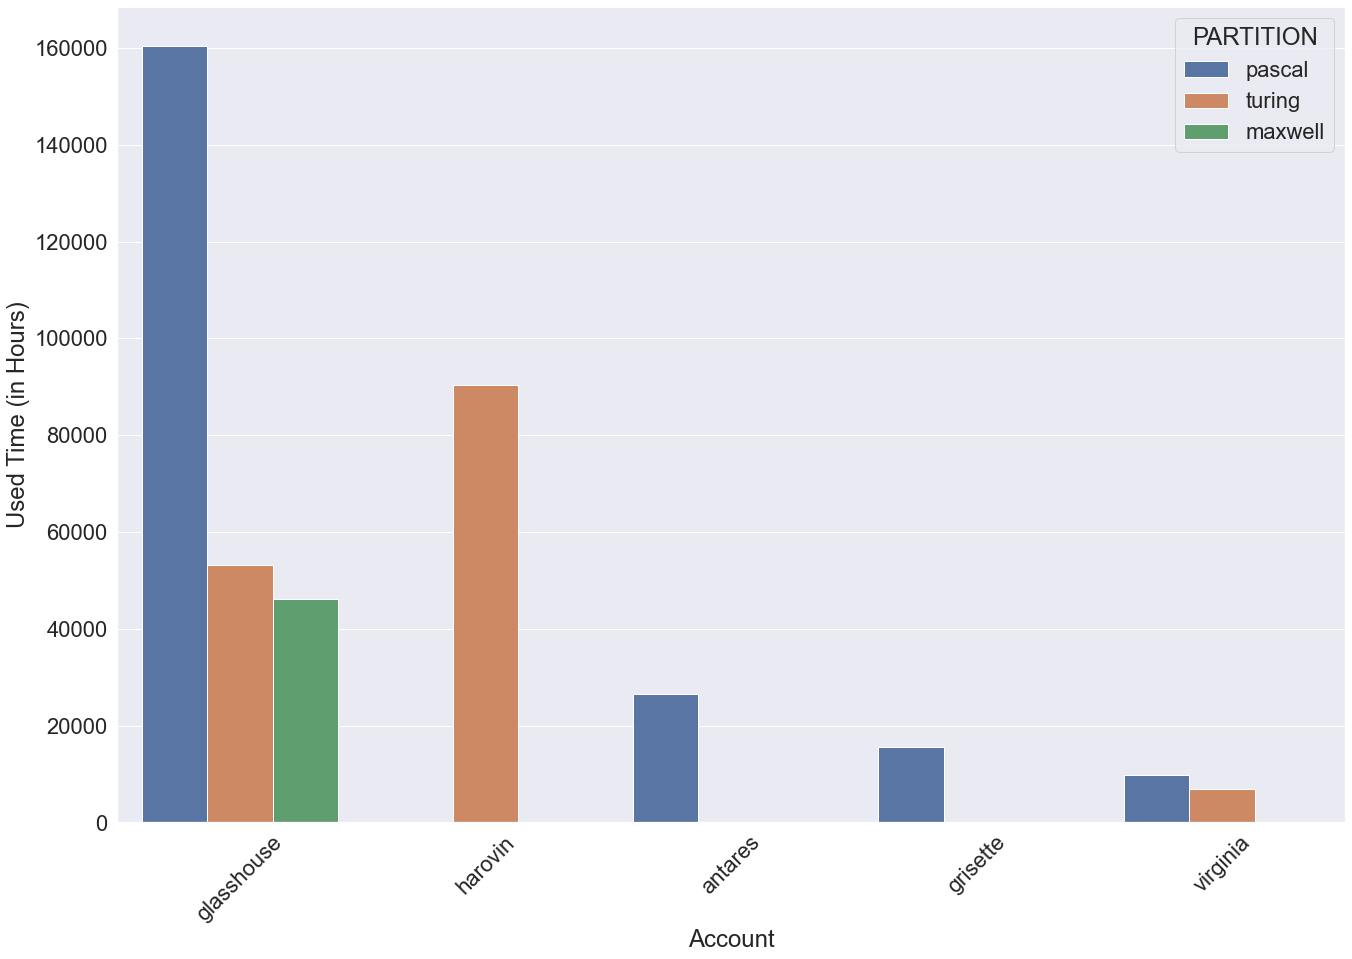

In [17]:
sns.set(font_scale=2)
plt.figure(figsize = (22,15))
sns.barplot(data = ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])['USEDTIME_Hours'].sum().sort_values(ascending= False).head(8).to_frame().reset_index(), x ='ACCOUNT', 
            y='USEDTIME_Hours', hue = 'PARTITION')
plt.ylabel('Used Time (in Hours)')
plt.xlabel('Account')
plt.xticks(rotation =45);



In [18]:
from plotly.subplots import make_subplots

In [19]:
import plotly.express as px
import plotly.graph_objects as go
from raceplotly.plots import barplot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'malanga'),
  Text(1, 0, 'glasshouse'),
  Text(2, 0, 'sunburst'),
  Text(3, 0, 'virginia'),
  Text(4, 0, 'antares'),
  Text(5, 0, 'harovin'),
  Text(6, 0, 'prince'),
  Text(7, 0, 'orange'),
  Text(8, 0, 'grisette'),
  Text(9, 0, 'horseradish'),
  Text(10, 0, 'pecans'),
  Text(11, 0, 'pinole'),
  Text(12, 0, 'clara'),
  Text(13, 0, 'pasilla'),
  Text(14, 0, 'plumcot'),
  Text(15, 0, 'kinnow'),
  Text(16, 0, 'almonds'),
  Text(17, 0, 'apple'),
  Text(18, 0, 'bunch'),
  Text(19, 0, 'bertanne'),
  Text(20, 0, 'cactus'),
  Text(21, 0, 'packham'),
  Text(22, 0, 'summer'),
  Text(23, 0, 'white'),
  Text(24, 0, 'sugranineteen'),
  Text(25, 0, 'gem'),
  Text(26, 0, 'rosemarie')])

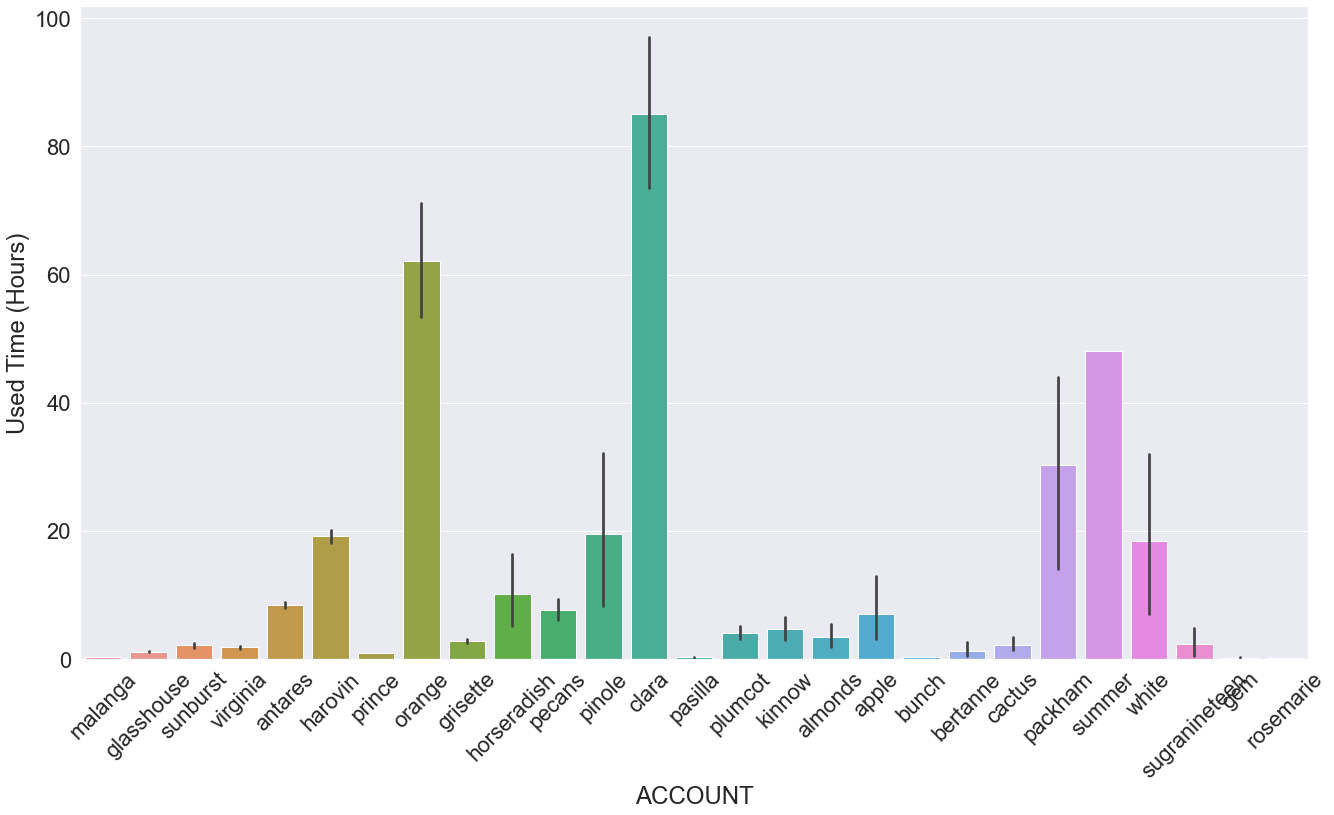

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(22, 12))
ax = sns.barplot(x='ACCOUNT', y='USEDTIME_Hours', data=ACCRE_Completed)
ax.set(ylabel='Used Time (Hours)')
plt.xticks(rotation = 45)


Ques 3: What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus)
in each of the 3 partitions over the last year?

In [21]:
ACCRE_completed_q3 = ACCRE_Completed
ACCRE_completed_q3["USAGE_PER_GPU"] = gpu_completed_df_q3["GPUS"] * gpu_completed_df_q3["USEDTIME_Hours"]
ACCRE_completed_q3.groupby(["PARTITION"])["USAGE_PER_GPU"].sum()

NameError: name 'gpu_completed_df_q3' is not defined

In [22]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='PARTITION', y='USEDTIME_Hours', data=ACCRE_completed_q3, color = )
ax.set(ylabel='Usage Per GPU')
plt.xticks(rotation = 45);



SyntaxError: invalid syntax (558020187.py, line 3)

ValueError: Could not interpret input 'USAGE_PER_GPU'

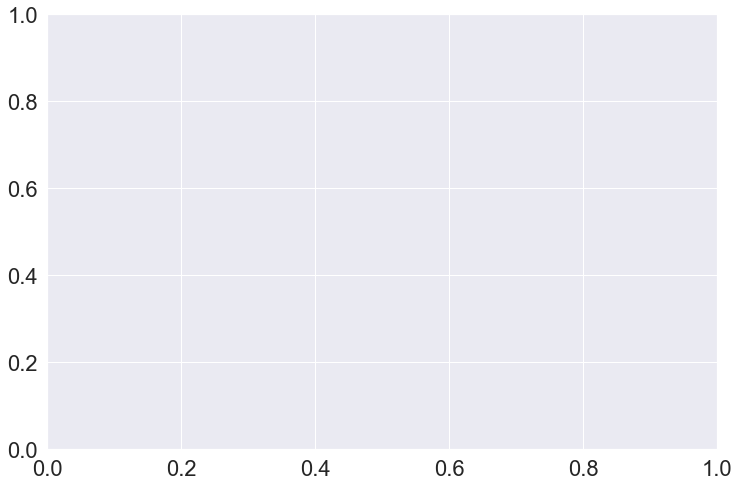

In [23]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = ACCRE_completed_q3 , x ='PARTITION', y ='USAGE_PER_GPU')
plt.xticks(rotation = 45);

In [ ]:
ACCRE_completed_q3.groupby(["PARTITION"])["GPUS"].sum()

Ques 4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

In [24]:
gpu_completed_df_q4 = ACCRE_Completed
gpu_completed_df_q4.groupby(["PARTITION","ACCOUNT","USER"])["USEDTIME_Hours"].sum().sort_values(ascending = False)

PARTITION  ACCOUNT     USER    
turing     harovin     porsha      72051.225000
pascal     glasshouse  collins     36128.736389
                       jolette     35495.081111
                       birdella    32735.093056
           antares     nakisha     25576.947500
                                       ...     
turing     glasshouse  gibson          0.001667
           bertanne    barbie          0.001389
pascal     glasshouse  margret         0.001111
           pecans      brigette        0.001111
maxwell    bertanne    ari             0.000000
Name: USEDTIME_Hours, Length: 265, dtype: float64

Ques 5 Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [26]:
ACCRE_Completed['Dif_Hours']= ACCRE_Completed['REQTIME_Hours'] - ACCRE_Completed['USEDTIME_Hours']

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_9399/752968205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACCRE_Completed['Dif_Hours']= ACCRE_Completed['REQTIME_Hours'] - ACCRE_Completed['USEDTIME_Hours']


In [27]:
ACCRE_Completed

JOBID     ACCOUNT     USER  USEDMEM     REQTIME  USEDTIME  \
0          32880657     malanga   arline    18.66  2-00:00:00  00:13:13   
1          32880701  glasshouse    brady     0.00    05:00:00  00:00:22   
2          32880718  glasshouse    brady   402.32    05:00:00  00:08:57   
3          32880719  glasshouse    brady   417.62    20:00:00  05:09:46   
4          32880720  glasshouse    brady   450.09    15:00:00  04:11:10   
...             ...         ...      ...      ...         ...       ...   
336933     46753813     harovin  shannon   137.96  5-00:00:00  00:00:52   
336934  46753820_26     harovin   porsha  5093.70  5-00:00:00  00:34:51   
336936     46753823     harovin  shannon   156.21  5-00:00:00  00:04:03   
336942     46754095     harovin  shannon  2820.52  5-00:00:00  00:11:13   
336948     46754598  glasshouse    treva   145.24  1-00:00:00  00:01:26   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
0           1     2     1    pascal      0:0  COMPLETED           48.0   
1           1     3     1   maxwell      0:0  COMPLETED            5.0   
2           1     3     1   maxwell      0:0  COMPLETED            5.0   
3           1     1     1    pascal      0:0  COMPLETED           20.0   
4           1     1     1    pascal      0:0  COMPLETED           15.0   
...       ...   ...   ...       ...      ...        ...            ...   
336933      1     1     1    turing      0:0  COMPLETED          120.0   
336934      1     6     1    turing      0:0  COMPLETED          120.0   
336936      1     1     1    turing      0:0  COMPLETED          120.0   
336942      1     1     1    turing      0:0  COMPLETED          120.0   
336948      1     5     1    turing      0:0  COMPLETED           24.0   

        USEDTIME_Hours   Dif_Hours  
0             0.220278   47.779722  
1             0.006111    4.993889  
2             0.149167    4.850833  
3             5.162778   14.837222  
4             4.186111   10.813889  
...                ...         ...  
336933        0.014444  119.985556  
336934        0.580833  119.419167  
336936        0.067500  119.932500  
336942        0.186944  119.813056  
336948        0.023889   23.976111  

[283333 rows x 15 columns]

In [28]:
len(ACCRE_Completed[ACCRE_Completed["Dif_Hours"] <= 0])

2916

In [29]:
ACCRE_Completed[ACCRE_Completed["Dif_Hours"] <= 0]

JOBID     ACCOUNT     USER  USEDMEM     REQTIME    USEDTIME  NODES  \
6       32880722  glasshouse    brady     0.00  3-12:00:00  3-12:00:07      1   
80      32881540    virginia  garrett  4039.36    02:00:00    02:00:05      1   
91      32882556    virginia  garrett    55.39    06:00:00    06:00:05      1   
92      32882567    virginia  garrett   281.12    06:00:00    06:00:05      1   
93      32882568    virginia  garrett    57.32    06:00:00    06:00:17      1   
...          ...         ...      ...      ...         ...         ...    ...   
336505  46652721  glasshouse     miya    82.70    10:00:00    10:00:26      1   
336628  46655849  glasshouse     miya    72.32    10:00:00    10:00:01      1   
336630  46655855    virginia  diandra   407.18    02:00:00    02:00:06      1   
336808  46745423    virginia  diandra   464.67    04:00:00    04:00:01      1   
336867  46751426    virginia  marland  2252.57    03:00:00    03:00:16      1   

        CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
6          1     1    pascal      0:0  COMPLETED           84.0   
80         6     1    turing      0:0  COMPLETED            2.0   
91         6     1    turing      0:0  COMPLETED            6.0   
92         6     1    turing      0:0  COMPLETED            6.0   
93         6     1    turing      0:0  COMPLETED            6.0   
...      ...   ...       ...      ...        ...            ...   
336505     1     1    pascal      0:0  COMPLETED           10.0   
336628     1     1    pascal      0:0  COMPLETED           10.0   
336630     6     1    turing      0:0  COMPLETED            2.0   
336808     6     1    turing      0:0  COMPLETED            4.0   
336867     2     1    pascal      0:0  COMPLETED            3.0   

        USEDTIME_Hours  Dif_Hours  
6            84.001944  -0.001944  
80            2.001389  -0.001389  
91            6.001389  -0.001389  
92            6.001389  -0.001389  
93            6.004722  -0.004722  
...                ...        ...  
336505       10.007222  -0.007222  
336628       10.000278  -0.000278  
336630        2.001667  -0.001667  
336808        4.000278  -0.000278  
336867        3.004444  -0.004444  

[2916 rows x 15 columns]

In [30]:
len(ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > 120])

750

In [31]:
ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > 120]

JOBID     ACCOUNT     USER   USEDMEM     REQTIME    USEDTIME  \
1825     32902926_2     harovin  shannon      0.00  5-00:00:00  5-00:00:15   
1826     32902926_3     harovin  shannon      0.00  5-00:00:00  5-00:00:15   
1827     32902926_4     harovin  shannon      0.00  5-00:00:00  5-00:00:15   
10954      32959839  glasshouse    erick    231.29  5-00:00:00  5-00:00:16   
10955      32959840  glasshouse    erick    230.78  5-00:00:00  5-00:00:16   
...             ...         ...      ...       ...         ...         ...   
334946     46534408     harovin   porsha   4024.16  5-00:00:00  5-00:00:14   
334947     46534411     harovin   porsha   4886.82  5-00:00:00  5-00:00:14   
335255     46558594     harovin   porsha   4097.02  5-00:00:00  5-00:00:25   
335582  46573206_34     harovin   porsha  38337.19  5-00:00:00  5-00:00:22   
335583  46573206_35     harovin   porsha  38971.33  5-00:00:00  5-00:00:22   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
1825        1     1     1    turing      0:0  COMPLETED          120.0   
1826        1     1     1    turing      0:0  COMPLETED          120.0   
1827        1     1     1    turing      0:0  COMPLETED          120.0   
10954       1     1     1   maxwell      0:0  COMPLETED          120.0   
10955       1     1     1   maxwell      0:0  COMPLETED          120.0   
...       ...   ...   ...       ...      ...        ...            ...   
334946      1     6     1    turing      0:0  COMPLETED          120.0   
334947      1     6     1    turing      0:0  COMPLETED          120.0   
335255      1     6     1    turing      0:0  COMPLETED          120.0   
335582      1     6     1    turing      0:0  COMPLETED          120.0   
335583      1     6     1    turing      0:0  COMPLETED          120.0   

        USEDTIME_Hours  Dif_Hours  
1825        120.004167  -0.004167  
1826        120.004167  -0.004167  
1827        120.004167  -0.004167  
10954       120.004444  -0.004444  
10955       120.004444  -0.004444  
...                ...        ...  
334946      120.003889  -0.003889  
334947      120.003889  -0.003889  
335255      120.006944  -0.006944  
335582      120.006111  -0.006111  
335583      120.006111  -0.006111  

[750 rows x 15 columns]

In [32]:
ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > ACCRE_Completed["REQTIME_Hours"]]

JOBID     ACCOUNT     USER  USEDMEM     REQTIME    USEDTIME  NODES  \
6       32880722  glasshouse    brady     0.00  3-12:00:00  3-12:00:07      1   
80      32881540    virginia  garrett  4039.36    02:00:00    02:00:05      1   
91      32882556    virginia  garrett    55.39    06:00:00    06:00:05      1   
92      32882567    virginia  garrett   281.12    06:00:00    06:00:05      1   
93      32882568    virginia  garrett    57.32    06:00:00    06:00:17      1   
...          ...         ...      ...      ...         ...         ...    ...   
336505  46652721  glasshouse     miya    82.70    10:00:00    10:00:26      1   
336628  46655849  glasshouse     miya    72.32    10:00:00    10:00:01      1   
336630  46655855    virginia  diandra   407.18    02:00:00    02:00:06      1   
336808  46745423    virginia  diandra   464.67    04:00:00    04:00:01      1   
336867  46751426    virginia  marland  2252.57    03:00:00    03:00:16      1   

        CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
6          1     1    pascal      0:0  COMPLETED           84.0   
80         6     1    turing      0:0  COMPLETED            2.0   
91         6     1    turing      0:0  COMPLETED            6.0   
92         6     1    turing      0:0  COMPLETED            6.0   
93         6     1    turing      0:0  COMPLETED            6.0   
...      ...   ...       ...      ...        ...            ...   
336505     1     1    pascal      0:0  COMPLETED           10.0   
336628     1     1    pascal      0:0  COMPLETED           10.0   
336630     6     1    turing      0:0  COMPLETED            2.0   
336808     6     1    turing      0:0  COMPLETED            4.0   
336867     2     1    pascal      0:0  COMPLETED            3.0   

        USEDTIME_Hours  Dif_Hours  
6            84.001944  -0.001944  
80            2.001389  -0.001389  
91            6.001389  -0.001389  
92            6.001389  -0.001389  
93            6.004722  -0.004722  
...                ...        ...  
336505       10.007222  -0.007222  
336628       10.000278  -0.000278  
336630        2.001667  -0.001667  
336808        4.000278  -0.000278  
336867        3.004444  -0.004444  

[2873 rows x 15 columns]

In [ ]:
ACCRE_Completed[ACCRE_Completed["REQTIME_Hours"] == 120] 

In [33]:
ACCRE_Completed["Percentage_Diff"]=((ACCRE_Completed["Dif_Hours"]/ACCRE_Completed["REQTIME_Hours"])*100)
ACCRE_Completed

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_9399/3196675637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACCRE_Completed["Percentage_Diff"]=((ACCRE_Completed["Dif_Hours"]/ACCRE_Completed["REQTIME_Hours"])*100)


JOBID     ACCOUNT     USER  USEDMEM     REQTIME  USEDTIME  \
0          32880657     malanga   arline    18.66  2-00:00:00  00:13:13   
1          32880701  glasshouse    brady     0.00    05:00:00  00:00:22   
2          32880718  glasshouse    brady   402.32    05:00:00  00:08:57   
3          32880719  glasshouse    brady   417.62    20:00:00  05:09:46   
4          32880720  glasshouse    brady   450.09    15:00:00  04:11:10   
...             ...         ...      ...      ...         ...       ...   
336933     46753813     harovin  shannon   137.96  5-00:00:00  00:00:52   
336934  46753820_26     harovin   porsha  5093.70  5-00:00:00  00:34:51   
336936     46753823     harovin  shannon   156.21  5-00:00:00  00:04:03   
336942     46754095     harovin  shannon  2820.52  5-00:00:00  00:11:13   
336948     46754598  glasshouse    treva   145.24  1-00:00:00  00:01:26   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
0           1     2     1    pascal      0:0  COMPLETED           48.0   
1           1     3     1   maxwell      0:0  COMPLETED            5.0   
2           1     3     1   maxwell      0:0  COMPLETED            5.0   
3           1     1     1    pascal      0:0  COMPLETED           20.0   
4           1     1     1    pascal      0:0  COMPLETED           15.0   
...       ...   ...   ...       ...      ...        ...            ...   
336933      1     1     1    turing      0:0  COMPLETED          120.0   
336934      1     6     1    turing      0:0  COMPLETED          120.0   
336936      1     1     1    turing      0:0  COMPLETED          120.0   
336942      1     1     1    turing      0:0  COMPLETED          120.0   
336948      1     5     1    turing      0:0  COMPLETED           24.0   

        USEDTIME_Hours   Dif_Hours  Percentage_Diff  
0             0.220278   47.779722        99.541088  
1             0.006111    4.993889        99.877778  
2             0.149167    4.850833        97.016667  
3             5.162778   14.837222        74.186111  
4             4.186111   10.813889        72.092593  
...                ...         ...              ...  
336933        0.014444  119.985556        99.987963  
336934        0.580833  119.419167        99.515972  
336936        0.067500  119.932500        99.943750  
336942        0.186944  119.813056        99.844213  
336948        0.023889   23.976111        99.900463  

[283333 rows x 16 columns]

In [34]:
ACCRE_Completed["Percentage_Diff"].describe()

count    283333.000000
mean         94.518289
std          15.401735
min         -93.472222
25%          98.553241
50%          99.452778
75%          99.886111
max         100.000000
Name: Percentage_Diff, dtype: float64

In [35]:
ACCRE_Completed["Dif_Hours"].describe()


count    283333.000000
mean         22.527946
std          33.752488
min         -20.064722
25%           5.995000
50%           9.951667
75%          11.626667
max         273.769444
Name: Dif_Hours, dtype: float64

In [36]:
ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > 131]

JOBID     ACCOUNT USER  USEDMEM      REQTIME    USEDTIME  NODES  \
82721  40954771  glasshouse  mel  7465.59  12-00:00:00  8-03:15:34      3   

       CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
82721    21    16    pascal      0:0  COMPLETED          288.0   

       USEDTIME_Hours  Dif_Hours  Percentage_Diff  
82721      195.259444  92.740556        32.201582

In [37]:
ACCRE_Completed[ACCRE_Completed["Dif_Hours"]>120]

JOBID     ACCOUNT    USER   USEDMEM      REQTIME    USEDTIME  \
60204   36136418  glasshouse  brodie    229.57  15-00:00:00  3-16:00:56   
60205   36136495  glasshouse  brodie    232.48  15-00:00:00  3-14:13:50   
332773  46291778      pinole  booker  92604.36  11-00:00:00  1-01:55:54   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
60204       1     1     1   maxwell      0:0  COMPLETED          360.0   
60205       1     1     1   maxwell      0:0  COMPLETED          360.0   
332773      1     6     1    turing      0:0  COMPLETED          264.0   

        USEDTIME_Hours   Dif_Hours  Percentage_Diff  
60204        88.015556  271.984444        75.551235  
60205        86.230556  273.769444        76.047068  
332773       25.931667  238.068333        90.177399

In [38]:
ACCRE_Completed["REQTIME_Hours"].describe()

count    283333.000000
mean         24.099913
std          35.493135
min           0.016667
25%          10.000000
50%          10.000000
75%          12.000000
max         360.000000
Name: REQTIME_Hours, dtype: float64

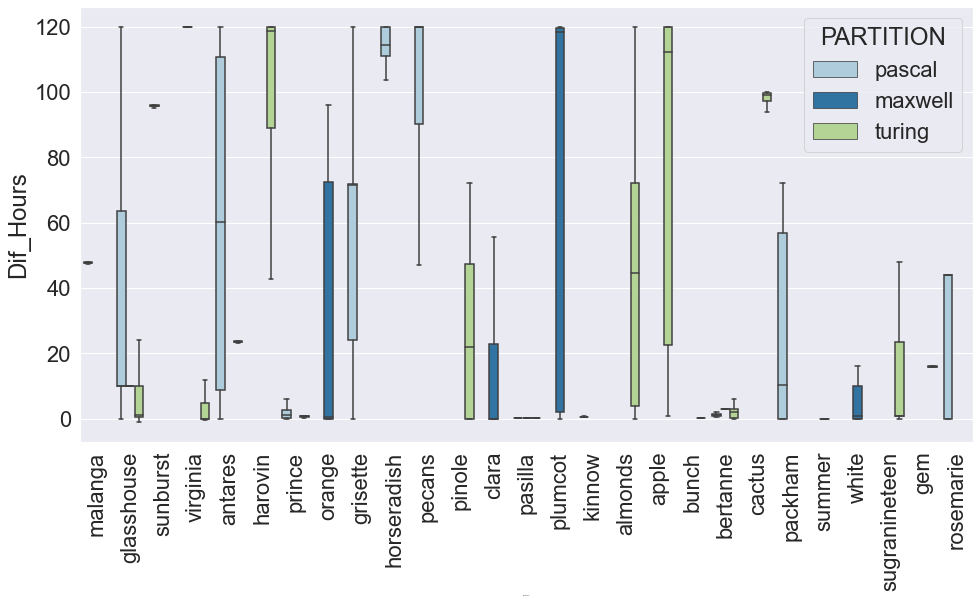

In [52]:
fig, ax = plt.subplots(figsize = (16,8))
sns.boxplot(data = ACCRE_Completed, x ='ACCOUNT', y ='Dif_Hours', hue = 'PARTITION', palette = 'Paired', showfliers = False)
plt.xlabel("Partition", fontsize = 2)
plt.xticks(rotation = 90);

In [90]:

ACCRE_Q5= ACCRE_Completed.groupby(["PARTITION","ACCOUNT"]).agg({'REQTIME_Hours':'sum','USEDTIME_Hours':'sum','USEDMEM':'sum', "JOBID":'count'}).sort_values(by=['JOBID'],ascending=False).reset_index()
ACCRE_Q5



PARTITION        ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM  \
0    maxwell     glasshouse   1.804962e+06    46154.247222  1.269025e+08   
1     turing     glasshouse   4.495486e+05    53106.674722  2.373583e+08   
2     pascal     glasshouse   1.614662e+06   160402.300556  9.812095e+07   
3     pascal        malanga   4.753440e+05     2508.606667  4.746145e+05   
4     pascal       virginia   1.032533e+06     9752.405000  3.572546e+07   
5     pascal         prince   2.274385e+04     6037.130833  2.505292e+07   
6     pascal       grisette   3.314860e+05    15535.382778  3.519797e+07   
7     turing        harovin   5.347660e+05    90274.837500  2.834613e+07   
8     pascal        antares   2.037474e+05    26643.297500  1.656117e+07   
9     pascal       sunburst   1.331600e+05     2858.116111  3.674696e+05   
10   maxwell        plumcot   9.111185e+04     4116.344722  2.657585e+06   
11    turing       virginia   1.172800e+04     6899.760556  1.606602e+07   
12    pascal         pecans   6.128172e+04     4616.035556  1.458480e+06   
13    turing        pasilla   7.669167e+02      142.452778  5.319890e+05   
14   maxwell        pasilla   2.396667e+02        3.985556  1.401675e+04   
15    pascal        pasilla   2.406667e+02       99.793611  3.493290e+03   
16    pascal         kinnow   7.417267e+03     1763.697222  2.466933e+06   
17    turing        almonds   8.998000e+03      647.675833  1.296163e+06   
18    turing       bertanne   1.205250e+03      205.256389  4.415936e+05   
19    turing         cactus   1.018240e+04      235.876667  3.772439e+05   
20    turing        antares   2.448000e+03       58.001111  3.392553e+05   
21   maxwell          clara   8.303633e+03     6463.001389  1.855386e+04   
22   maxwell         orange   6.880000e+03     4594.072500  3.090962e+06   
23    pascal      rosemarie   1.364400e+03        4.254722  1.980830e+04   
24    turing         prince   2.040000e+02      169.335556  3.086194e+05   
25    pascal    horseradish   5.644000e+03      483.200000  3.760822e+05   
26    turing          apple   4.062000e+03      310.253611  7.539953e+04   
27   maxwell          white   8.710000e+02      569.064444  4.534824e+04   
28    turing  sugranineteen   4.870000e+02       72.609722  3.045740e+03   
29   maxwell       bertanne   1.360000e+02       27.783056  3.864595e+04   
30    turing            gem   2.885000e+02        2.238889  4.640805e+04   
31    turing         pinole   1.025000e+03      370.590278  1.117187e+06   
32    pascal        packham   4.080000e+02      212.023056  2.359205e+04   
33    pascal       bertanne   6.500000e+00        1.607222  2.677300e+02   
34    turing          bunch   3.333333e-01        0.209444  6.090000e+00   
35   maxwell         summer   4.800000e+01       48.004722  9.266000e+01   

     JOBID  
0   125380  
1    68428  
2    43252  
3     9901  
4     8932  
5     7408  
6     5786  
7     4729  
8     3117  
9     1390  
10    1027  
11     624  
12     609  
13     477  
14     427  
15     425  
16     380  
17     189  
18     164  
19     113  
20      86  
21      76  
22      74  
23      55  
24      51  
25      48  
26      45  
27      31  
28      31  
29      27  
30      19  
31      19  
32       7  
33       4  
34       1  
35       1

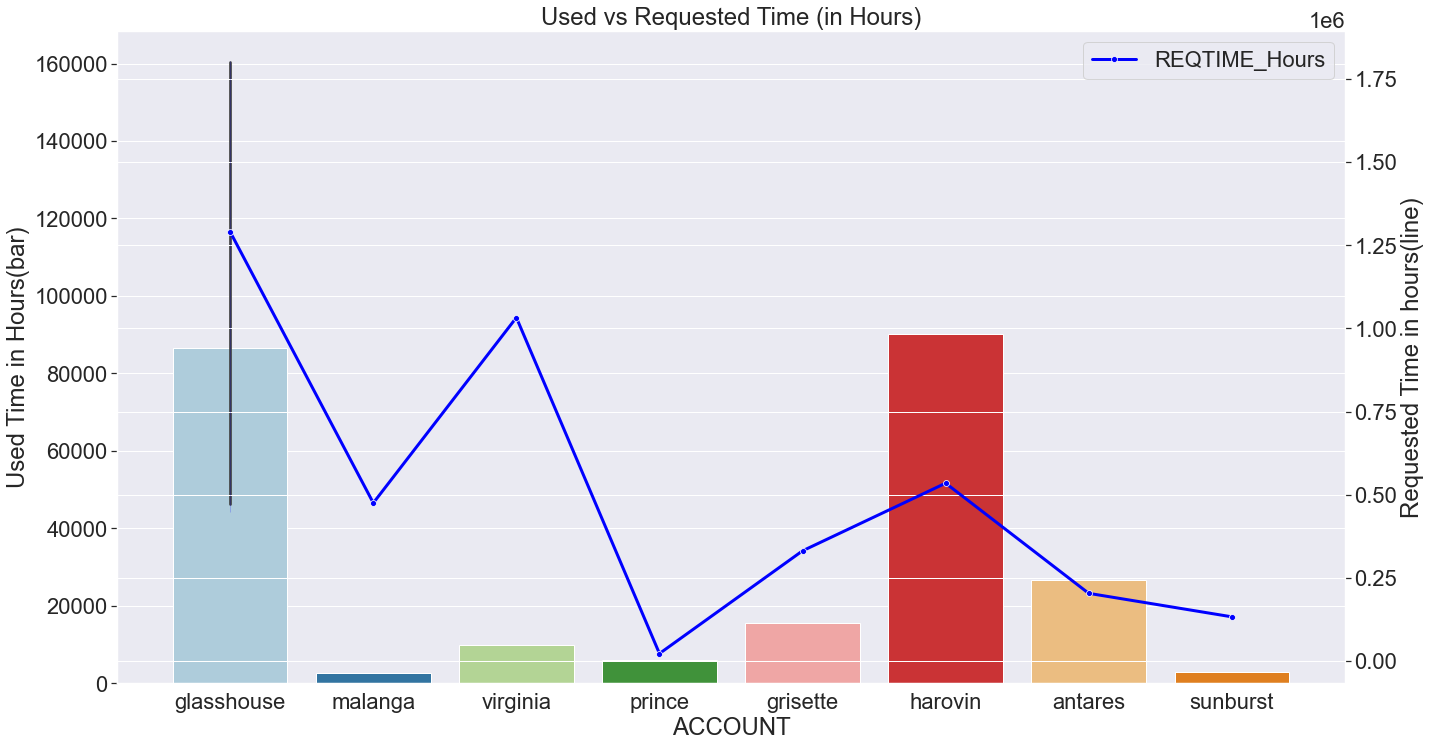

In [97]:
sns.set(font_scale=2)
plt.figure(figsize=(22, 12))
ax = sns.barplot(x='ACCOUNT', y='USEDTIME_Hours', data= ACCRE_Q5.head(10), label = 'USEDTIME_Hours', palette = 'Paired')
ax2 = ax.twinx()
sns.lineplot(x='ACCOUNT', y='REQTIME_Hours', data=ACCRE_Q5.head(10), marker='o', 
             color='Blue', lw=3, ax=ax2,label = 'REQTIME_Hours').set(title='Used vs Requested Time (in Hours)')

ax.set(ylabel='Used Time in Hours(bar)')
ax2.set(ylabel='Requested Time in hours(line)');


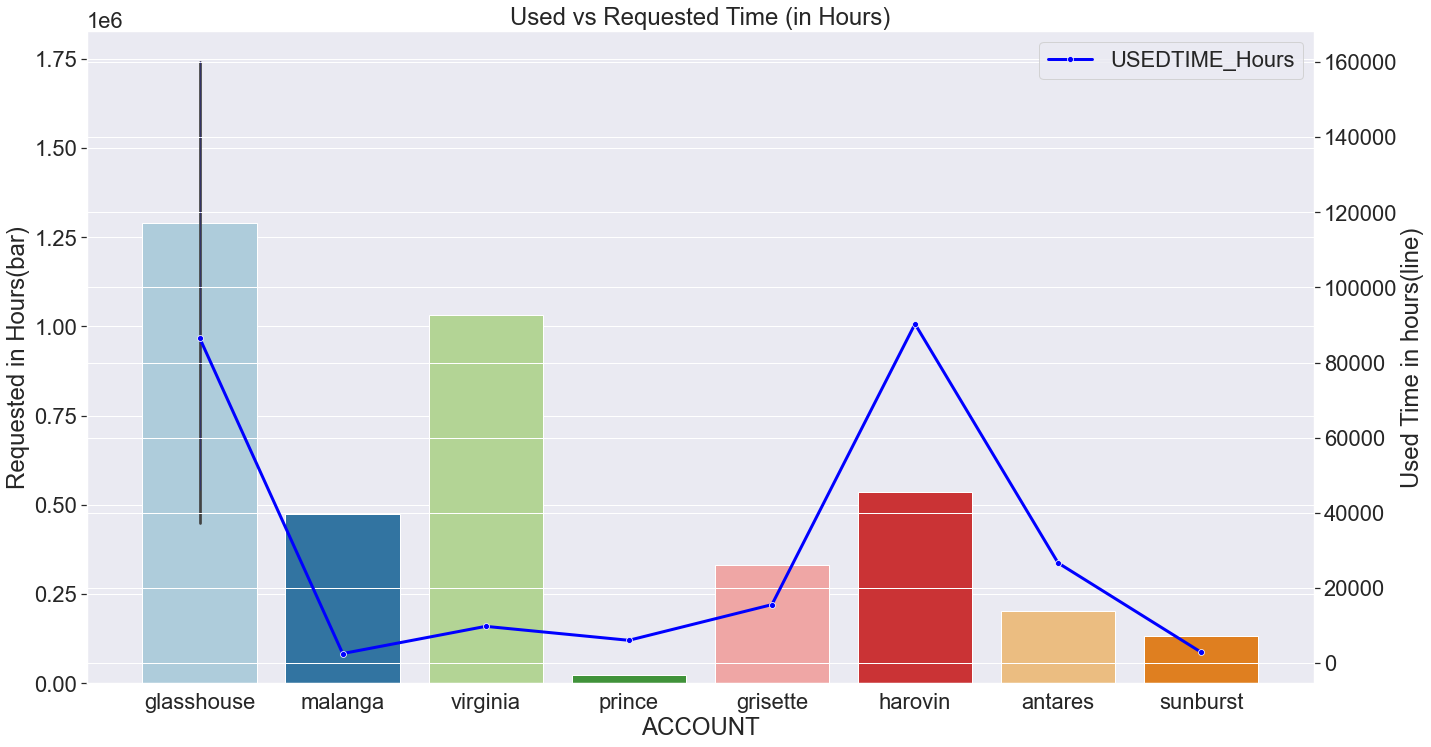

In [98]:
sns.set(font_scale=2)
plt.figure(figsize=(22, 12))
ax = sns.barplot(x='ACCOUNT', y='REQTIME_Hours', data= ACCRE_Q5.head(10), label = 'REQTIME_Hours', palette = 'Paired')
ax2 = ax.twinx()
sns.lineplot(x='ACCOUNT', y='USEDTIME_Hours', data=ACCRE_Q5.head(10), marker='o', 
             color='Blue', lw=3, ax=ax2,label = 'USEDTIME_Hours').set(title='Used vs Requested Time (in Hours)')

ax.set(ylabel='Requested in Hours(bar)')
ax2.set(ylabel='Used Time in hours(line)');

In [103]:
ACCRE_Completed.groupby(["PARTITION", "ACCOUNT"])["REQTIME_Hours"].sum().sort_values(ascending = False)



PARTITION  ACCOUNT      
maxwell    glasshouse       1.804962e+06
pascal     glasshouse       1.614662e+06
           virginia         1.032533e+06
turing     harovin          5.347660e+05
pascal     malanga          4.753440e+05
turing     glasshouse       4.495486e+05
pascal     grisette         3.314860e+05
           antares          2.037474e+05
           sunburst         1.331600e+05
maxwell    plumcot          9.111185e+04
pascal     pecans           6.128172e+04
           prince           2.274385e+04
turing     virginia         1.172800e+04
           cactus           1.018240e+04
           almonds          8.998000e+03
maxwell    clara            8.303633e+03
pascal     kinnow           7.417267e+03
maxwell    orange           6.880000e+03
pascal     horseradish      5.644000e+03
turing     apple            4.062000e+03
           antares          2.448000e+03
pascal     rosemarie        1.364400e+03
turing     bertanne         1.205250e+03
           pinole           1.02

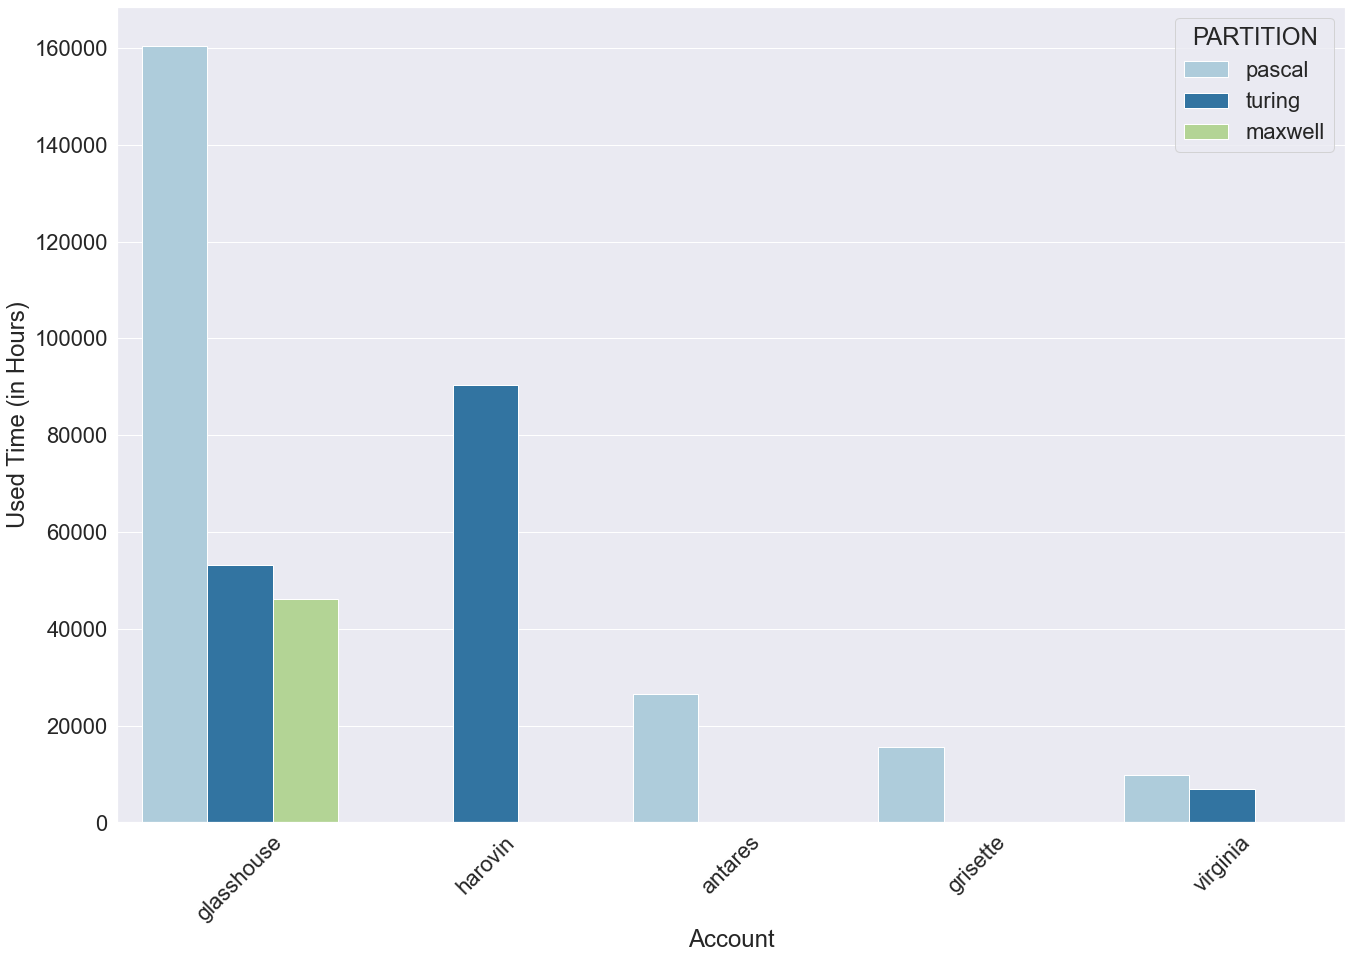

In [99]:
sns.set(font_scale=2)
plt.figure(figsize = (22,15))
sns.barplot(data = ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])['USEDTIME_Hours'].sum().sort_values(ascending= False).head(8).to_frame().reset_index(), x ='ACCOUNT', 
            y='USEDTIME_Hours', hue = 'PARTITION', palette = 'Paired')
plt.ylabel('Used Time (in Hours)')
plt.xlabel('Account')
plt.xticks(rotation =45);

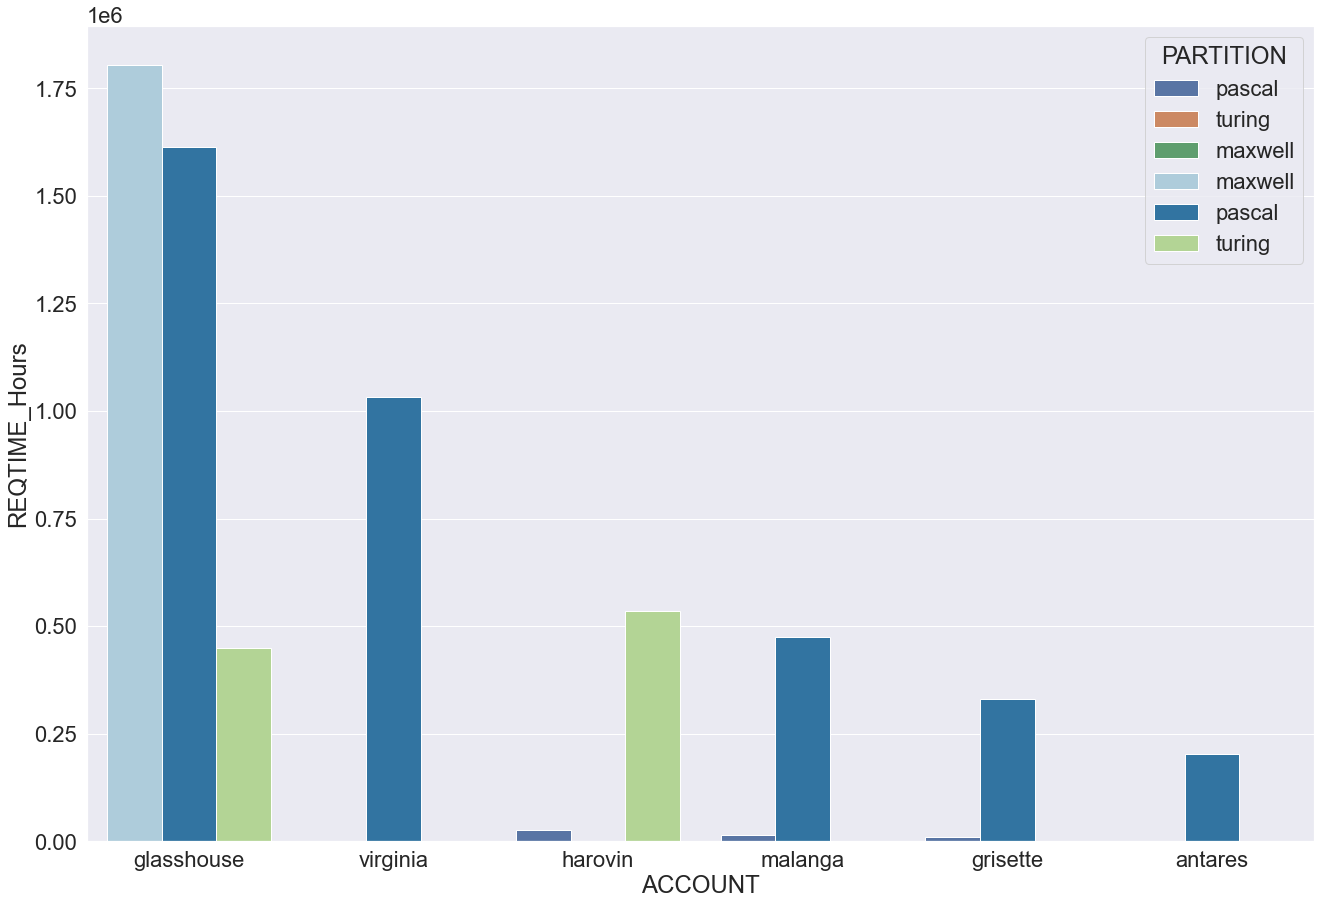

In [104]:
sns.set(font_scale=2)
plt.figure(figsize = (22,15))
s1 = sns.barplot(data = ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])['USEDTIME_Hours'].sum().sort_values(ascending= False).head(8).to_frame().reset_index(), x ='ACCOUNT', 
            y='USEDTIME_Hours', hue = 'PARTITION')

s2 = sns.barplot(data = ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])['REQTIME_Hours'].sum().sort_values(ascending= False).head(8).to_frame().reset_index(), x ='ACCOUNT', 
            y='REQTIME_Hours', hue = 'PARTITION', palette = 'Paired')

In [39]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 72)])  
                     

2875

In [ ]:
ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 72)]


In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 72) & (ACCRE_Completed["REQTIME_Hours"] <= 96)])  
                     

In [ ]:
ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 72) & (ACCRE_Completed["REQTIME_Hours"] <= 96)] 
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 96) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 0.5) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 96) & (ACCRE_Completed["REQTIME_Hours"] <= 120)]


In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.5) & (ACCRE_Completed["USEDTIME_Hours"] <= 1.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 1.0) & (ACCRE_Completed["USEDTIME_Hours"] <= 2.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 2.0) & (ACCRE_Completed["USEDTIME_Hours"] <= 3.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 3.0) & (ACCRE_Completed["USEDTIME_Hours"] <= 5.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 5.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     

In [ ]:
len(ACCRE_Completed[(ACCRE_Completed["USEDTIME_Hours"] >= 0.25) & (ACCRE_Completed["USEDTIME_Hours"] <= 5.0) &
                    (ACCRE_Completed["REQTIME_Hours"] >= 48) & (ACCRE_Completed["REQTIME_Hours"] <= 120)])  
                     /ACCRE_Completed

In [106]:
import plotly.graph_objects as go
import plotly.express as px

In [107]:

gpu_completed_df_Top20_Accounts = (
    ACCRE_Completed.groupby(['ACCOUNT'])
    .agg({'REQTIME_Hours':'sum','USEDTIME_Hours':'sum','USEDMEM':'sum', "JOBID":'count'})
    .sort_values(by=['JOBID'],ascending=False)
    .reset_index()
    .head(20)
)

gpu_completed_df_Top20_Accounts

gpu_completed_df_Top20_Accounts["UsedoverReqPcnt"] = (gpu_completed_df_Top20_Accounts["USEDTIME_Hours"] / gpu_completed_df_Top20_Accounts["REQTIME_Hours"] * 100 ).round(2)

fig = px.scatter(gpu_completed_df_Top20_Accounts.head(10), x="USEDTIME_Hours", y="REQTIME_Hours",
          size="UsedoverReqPcnt", color="ACCOUNT",
                 hover_name="ACCOUNT", log_x=True, size_max=60)
fig.show()
gpu_completed_df_Top20_Accounts






ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM   JOBID  \
0    glasshouse   3.869172e+06   259663.222500  4.623817e+08  237060   
1       malanga   4.753440e+05     2508.606667  4.746145e+05    9901   
2      virginia   1.044261e+06    16652.165556  5.179148e+07    9556   
3        prince   2.294785e+04     6206.466389  2.536154e+07    7459   
4      grisette   3.314860e+05    15535.382778  3.519797e+07    5786   
5       harovin   5.347660e+05    90274.837500  2.834613e+07    4729   
6       antares   2.061954e+05    26701.298611  1.690043e+07    3203   
7      sunburst   1.331600e+05     2858.116111  3.674696e+05    1390   
8       pasilla   1.247250e+03      246.231944  5.494990e+05    1329   
9       plumcot   9.111185e+04     4116.344722  2.657585e+06    1027   
10       pecans   6.128172e+04     4616.035556  1.458480e+06     609   
11       kinnow   7.417267e+03     1763.697222  2.466933e+06     380   
12     bertanne   1.347750e+03      234.646667  4.805073e+05     195   
13      almonds   8.998000e+03      647.675833  1.296163e+06     189   
14       cactus   1.018240e+04      235.876667  3.772439e+05     113   
15        clara   8.303633e+03     6463.001389  1.855386e+04      76   
16       orange   6.880000e+03     4594.072500  3.090962e+06      74   
17    rosemarie   1.364400e+03        4.254722  1.980830e+04      55   
18  horseradish   5.644000e+03      483.200000  3.760822e+05      48   
19        apple   4.062000e+03      310.253611  7.539953e+04      45   

    UsedoverReqPcnt  
0              6.71  
1              0.53  
2              1.59  
3             27.05  
4              4.69  
5             16.88  
6             12.95  
7              2.15  
8             19.74  
9              4.52  
10             7.53  
11            23.78  
12            17.41  
13             7.20  
14             2.32  
15            77.83  
16            66.77  
17             0.31  
18             8.56  
19             7.64

In [108]:

fig = px.scatter(gpu_completed_df_Top20_Accounts.head(10), x="USEDTIME_Hours", y="REQTIME_Hours",
          size="UsedoverReqPcnt", color="JOBID",
                 hover_name="ACCOUNT", log_x=True, size_max=60)
fig.show()
gpu_completed_df_Top20_Accounts





ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM   JOBID  \
0    glasshouse   3.869172e+06   259663.222500  4.623817e+08  237060   
1       malanga   4.753440e+05     2508.606667  4.746145e+05    9901   
2      virginia   1.044261e+06    16652.165556  5.179148e+07    9556   
3        prince   2.294785e+04     6206.466389  2.536154e+07    7459   
4      grisette   3.314860e+05    15535.382778  3.519797e+07    5786   
5       harovin   5.347660e+05    90274.837500  2.834613e+07    4729   
6       antares   2.061954e+05    26701.298611  1.690043e+07    3203   
7      sunburst   1.331600e+05     2858.116111  3.674696e+05    1390   
8       pasilla   1.247250e+03      246.231944  5.494990e+05    1329   
9       plumcot   9.111185e+04     4116.344722  2.657585e+06    1027   
10       pecans   6.128172e+04     4616.035556  1.458480e+06     609   
11       kinnow   7.417267e+03     1763.697222  2.466933e+06     380   
12     bertanne   1.347750e+03      234.646667  4.805073e+05     195   
13      almonds   8.998000e+03      647.675833  1.296163e+06     189   
14       cactus   1.018240e+04      235.876667  3.772439e+05     113   
15        clara   8.303633e+03     6463.001389  1.855386e+04      76   
16       orange   6.880000e+03     4594.072500  3.090962e+06      74   
17    rosemarie   1.364400e+03        4.254722  1.980830e+04      55   
18  horseradish   5.644000e+03      483.200000  3.760822e+05      48   
19        apple   4.062000e+03      310.253611  7.539953e+04      45   

    UsedoverReqPcnt  
0              6.71  
1              0.53  
2              1.59  
3             27.05  
4              4.69  
5             16.88  
6             12.95  
7              2.15  
8             19.74  
9              4.52  
10             7.53  
11            23.78  
12            17.41  
13             7.20  
14             2.32  
15            77.83  
16            66.77  
17             0.31  
18             8.56  
19             7.64

In [109]:
gpu_completed_df_Top20_Accounts["UsedoverReqPcnt_Diff"] = (((gpu_completed_df_Top20_Accounts["REQTIME_Hours"] - gpu_completed_df_Top20_Accounts["USEDTIME_Hours"])/gpu_completed_df_Top20_Accounts["REQTIME_Hours"])* 100 ).round(2)

gpu_completed_df_Top20_Accounts

fig = px.scatter(gpu_completed_df_Top20_Accounts, x="USEDTIME_Hours", y="REQTIME_Hours",
          size="UsedoverReqPcnt_Diff", color="ACCOUNT",
                 hover_name="ACCOUNT", log_x=True, size_max=50)
fig.show()
gpu_completed_df_Top20_Accounts




ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM   JOBID  \
0    glasshouse   3.869172e+06   259663.222500  4.623817e+08  237060   
1       malanga   4.753440e+05     2508.606667  4.746145e+05    9901   
2      virginia   1.044261e+06    16652.165556  5.179148e+07    9556   
3        prince   2.294785e+04     6206.466389  2.536154e+07    7459   
4      grisette   3.314860e+05    15535.382778  3.519797e+07    5786   
5       harovin   5.347660e+05    90274.837500  2.834613e+07    4729   
6       antares   2.061954e+05    26701.298611  1.690043e+07    3203   
7      sunburst   1.331600e+05     2858.116111  3.674696e+05    1390   
8       pasilla   1.247250e+03      246.231944  5.494990e+05    1329   
9       plumcot   9.111185e+04     4116.344722  2.657585e+06    1027   
10       pecans   6.128172e+04     4616.035556  1.458480e+06     609   
11       kinnow   7.417267e+03     1763.697222  2.466933e+06     380   
12     bertanne   1.347750e+03      234.646667  4.805073e+05     195   
13      almonds   8.998000e+03      647.675833  1.296163e+06     189   
14       cactus   1.018240e+04      235.876667  3.772439e+05     113   
15        clara   8.303633e+03     6463.001389  1.855386e+04      76   
16       orange   6.880000e+03     4594.072500  3.090962e+06      74   
17    rosemarie   1.364400e+03        4.254722  1.980830e+04      55   
18  horseradish   5.644000e+03      483.200000  3.760822e+05      48   
19        apple   4.062000e+03      310.253611  7.539953e+04      45   

    UsedoverReqPcnt  UsedoverReqPcnt_Diff  
0              6.71                 93.29  
1              0.53                 99.47  
2              1.59                 98.41  
3             27.05                 72.95  
4              4.69                 95.31  
5             16.88                 83.12  
6             12.95                 87.05  
7              2.15                 97.85  
8             19.74                 80.26  
9              4.52                 95.48  
10             7.53                 92.47  
11            23.78                 76.22  
12            17.41                 82.59  
13             7.20                 92.80  
14             2.32                 97.68  
15            77.83                 22.17  
16            66.77                 33.23  
17             0.31                 99.69  
18             8.56                 91.44  
19             7.64                 92.36

In [110]:
gpu_completed_df_Top20_Accounts["UsedoverReqPcnt_Diff"] = (((gpu_completed_df_Top20_Accounts["REQTIME_Hours"] - gpu_completed_df_Top20_Accounts["USEDTIME_Hours"])/gpu_completed_df_Top20_Accounts["REQTIME_Hours"])* 100 ).round(2)

gpu_completed_df_Top20_Accounts

fig = px.scatter(gpu_completed_df_Top20_Accounts, x="USEDTIME_Hours", y="REQTIME_Hours",
          size="JOBID", color="ACCOUNT",
                 hover_name="ACCOUNT", log_x=True, size_max=50)
fig.show()
gpu_completed_df_Top20_Accounts





ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM   JOBID  \
0    glasshouse   3.869172e+06   259663.222500  4.623817e+08  237060   
1       malanga   4.753440e+05     2508.606667  4.746145e+05    9901   
2      virginia   1.044261e+06    16652.165556  5.179148e+07    9556   
3        prince   2.294785e+04     6206.466389  2.536154e+07    7459   
4      grisette   3.314860e+05    15535.382778  3.519797e+07    5786   
5       harovin   5.347660e+05    90274.837500  2.834613e+07    4729   
6       antares   2.061954e+05    26701.298611  1.690043e+07    3203   
7      sunburst   1.331600e+05     2858.116111  3.674696e+05    1390   
8       pasilla   1.247250e+03      246.231944  5.494990e+05    1329   
9       plumcot   9.111185e+04     4116.344722  2.657585e+06    1027   
10       pecans   6.128172e+04     4616.035556  1.458480e+06     609   
11       kinnow   7.417267e+03     1763.697222  2.466933e+06     380   
12     bertanne   1.347750e+03      234.646667  4.805073e+05     195   
13      almonds   8.998000e+03      647.675833  1.296163e+06     189   
14       cactus   1.018240e+04      235.876667  3.772439e+05     113   
15        clara   8.303633e+03     6463.001389  1.855386e+04      76   
16       orange   6.880000e+03     4594.072500  3.090962e+06      74   
17    rosemarie   1.364400e+03        4.254722  1.980830e+04      55   
18  horseradish   5.644000e+03      483.200000  3.760822e+05      48   
19        apple   4.062000e+03      310.253611  7.539953e+04      45   

    UsedoverReqPcnt  UsedoverReqPcnt_Diff  
0              6.71                 93.29  
1              0.53                 99.47  
2              1.59                 98.41  
3             27.05                 72.95  
4              4.69                 95.31  
5             16.88                 83.12  
6             12.95                 87.05  
7              2.15                 97.85  
8             19.74                 80.26  
9              4.52                 95.48  
10             7.53                 92.47  
11            23.78                 76.22  
12            17.41                 82.59  
13             7.20                 92.80  
14             2.32                 97.68  
15            77.83                 22.17  
16            66.77                 33.23  
17             0.31                 99.69  
18             8.56                 91.44  
19             7.64                 92.36

In [111]:

fig = px.scatter(gpu_completed_df_Top20_Accounts.head(10), x="USEDTIME_Hours", y="REQTIME_Hours",
          size="UsedoverReqPcnt", color="ACCOUNT",
                 hover_name="ACCOUNT", log_x=True, size_max=60)
fig.show()
gpu_completed_df_Top20_Accounts

ACCRE_Completed["Percentage_Diff"]=((ACCRE_Completed["Dif_Hours"]/ACCRE_Completed["REQTIME_Hours"])*100)
ACCRE_Completed


/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_9399/314453269.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



JOBID     ACCOUNT     USER  USEDMEM     REQTIME  USEDTIME  \
0          32880657     malanga   arline    18.66  2-00:00:00  00:13:13   
1          32880701  glasshouse    brady     0.00    05:00:00  00:00:22   
2          32880718  glasshouse    brady   402.32    05:00:00  00:08:57   
3          32880719  glasshouse    brady   417.62    20:00:00  05:09:46   
4          32880720  glasshouse    brady   450.09    15:00:00  04:11:10   
...             ...         ...      ...      ...         ...       ...   
336933     46753813     harovin  shannon   137.96  5-00:00:00  00:00:52   
336934  46753820_26     harovin   porsha  5093.70  5-00:00:00  00:34:51   
336936     46753823     harovin  shannon   156.21  5-00:00:00  00:04:03   
336942     46754095     harovin  shannon  2820.52  5-00:00:00  00:11:13   
336948     46754598  glasshouse    treva   145.24  1-00:00:00  00:01:26   

        NODES  CPUS  GPUS PARTITION EXITCODE      STATE  REQTIME_Hours  \
0           1     2     1    pascal      0:0  COMPLETED           48.0   
1           1     3     1   maxwell      0:0  COMPLETED            5.0   
2           1     3     1   maxwell      0:0  COMPLETED            5.0   
3           1     1     1    pascal      0:0  COMPLETED           20.0   
4           1     1     1    pascal      0:0  COMPLETED           15.0   
...       ...   ...   ...       ...      ...        ...            ...   
336933      1     1     1    turing      0:0  COMPLETED          120.0   
336934      1     6     1    turing      0:0  COMPLETED          120.0   
336936      1     1     1    turing      0:0  COMPLETED          120.0   
336942      1     1     1    turing      0:0  COMPLETED          120.0   
336948      1     5     1    turing      0:0  COMPLETED           24.0   

        USEDTIME_Hours   Dif_Hours  Percentage_Diff  
0             0.220278   47.779722        99.541088  
1             0.006111    4.993889        99.877778  
2             0.149167    4.850833        97.016667  
3             5.162778   14.837222        74.186111  
4             4.186111   10.813889        72.092593  
...                ...         ...              ...  
336933        0.014444  119.985556        99.987963  
336934        0.580833  119.419167        99.515972  
336936        0.067500  119.932500        99.943750  
336942        0.186944  119.813056        99.844213  
336948        0.023889   23.976111        99.900463  

[283333 rows x 16 columns]

In [112]:
fig = px.scatter(gpu_completed_df_Top20_Accounts, x="USEDTIME_Hours", y="REQTIME_Hours",
          size="UsedoverReqPcnt", color="ACCOUNT",
                 hover_name="ACCOUNT", log_x=True, size_max=60)
fig.show()
gpu_completed_df_Top20_Accounts




ACCOUNT  REQTIME_Hours  USEDTIME_Hours       USEDMEM   JOBID  \
0    glasshouse   3.869172e+06   259663.222500  4.623817e+08  237060   
1       malanga   4.753440e+05     2508.606667  4.746145e+05    9901   
2      virginia   1.044261e+06    16652.165556  5.179148e+07    9556   
3        prince   2.294785e+04     6206.466389  2.536154e+07    7459   
4      grisette   3.314860e+05    15535.382778  3.519797e+07    5786   
5       harovin   5.347660e+05    90274.837500  2.834613e+07    4729   
6       antares   2.061954e+05    26701.298611  1.690043e+07    3203   
7      sunburst   1.331600e+05     2858.116111  3.674696e+05    1390   
8       pasilla   1.247250e+03      246.231944  5.494990e+05    1329   
9       plumcot   9.111185e+04     4116.344722  2.657585e+06    1027   
10       pecans   6.128172e+04     4616.035556  1.458480e+06     609   
11       kinnow   7.417267e+03     1763.697222  2.466933e+06     380   
12     bertanne   1.347750e+03      234.646667  4.805073e+05     195   
13      almonds   8.998000e+03      647.675833  1.296163e+06     189   
14       cactus   1.018240e+04      235.876667  3.772439e+05     113   
15        clara   8.303633e+03     6463.001389  1.855386e+04      76   
16       orange   6.880000e+03     4594.072500  3.090962e+06      74   
17    rosemarie   1.364400e+03        4.254722  1.980830e+04      55   
18  horseradish   5.644000e+03      483.200000  3.760822e+05      48   
19        apple   4.062000e+03      310.253611  7.539953e+04      45   

    UsedoverReqPcnt  UsedoverReqPcnt_Diff  
0              6.71                 93.29  
1              0.53                 99.47  
2              1.59                 98.41  
3             27.05                 72.95  
4              4.69                 95.31  
5             16.88                 83.12  
6             12.95                 87.05  
7              2.15                 97.85  
8             19.74                 80.26  
9              4.52                 95.48  
10             7.53                 92.47  
11            23.78                 76.22  
12            17.41                 82.59  
13             7.20                 92.80  
14             2.32                 97.68  
15            77.83                 22.17  
16            66.77                 33.23  
17             0.31                 99.69  
18             8.56                 91.44  
19             7.64                 92.36

In [121]:
gpu_completed_df_Top20_Accounts_2 = (
    ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])
    .agg({'REQTIME_Hours':'sum','USEDTIME_Hours':'sum','USEDMEM':'sum', "JOBID":'count'})
    .sort_values(by=['JOBID'],ascending=False)
    .reset_index()
)
gpu_completed_df_Top20_Accounts_2




ACCOUNT PARTITION  REQTIME_Hours  USEDTIME_Hours       USEDMEM  \
0      glasshouse   maxwell   1.804962e+06    46154.247222  1.269025e+08   
1      glasshouse    turing   4.495486e+05    53106.674722  2.373583e+08   
2      glasshouse    pascal   1.614662e+06   160402.300556  9.812095e+07   
3         malanga    pascal   4.753440e+05     2508.606667  4.746145e+05   
4        virginia    pascal   1.032533e+06     9752.405000  3.572546e+07   
5          prince    pascal   2.274385e+04     6037.130833  2.505292e+07   
6        grisette    pascal   3.314860e+05    15535.382778  3.519797e+07   
7         harovin    turing   5.347660e+05    90274.837500  2.834613e+07   
8         antares    pascal   2.037474e+05    26643.297500  1.656117e+07   
9        sunburst    pascal   1.331600e+05     2858.116111  3.674696e+05   
10        plumcot   maxwell   9.111185e+04     4116.344722  2.657585e+06   
11       virginia    turing   1.172800e+04     6899.760556  1.606602e+07   
12         pecans    pascal   6.128172e+04     4616.035556  1.458480e+06   
13        pasilla    turing   7.669167e+02      142.452778  5.319890e+05   
14        pasilla   maxwell   2.396667e+02        3.985556  1.401675e+04   
15        pasilla    pascal   2.406667e+02       99.793611  3.493290e+03   
16         kinnow    pascal   7.417267e+03     1763.697222  2.466933e+06   
17        almonds    turing   8.998000e+03      647.675833  1.296163e+06   
18       bertanne    turing   1.205250e+03      205.256389  4.415936e+05   
19         cactus    turing   1.018240e+04      235.876667  3.772439e+05   
20        antares    turing   2.448000e+03       58.001111  3.392553e+05   
21          clara   maxwell   8.303633e+03     6463.001389  1.855386e+04   
22         orange   maxwell   6.880000e+03     4594.072500  3.090962e+06   
23      rosemarie    pascal   1.364400e+03        4.254722  1.980830e+04   
24         prince    turing   2.040000e+02      169.335556  3.086194e+05   
25    horseradish    pascal   5.644000e+03      483.200000  3.760822e+05   
26          apple    turing   4.062000e+03      310.253611  7.539953e+04   
27  sugranineteen    turing   4.870000e+02       72.609722  3.045740e+03   
28          white   maxwell   8.710000e+02      569.064444  4.534824e+04   
29       bertanne   maxwell   1.360000e+02       27.783056  3.864595e+04   
30         pinole    turing   1.025000e+03      370.590278  1.117187e+06   
31            gem    turing   2.885000e+02        2.238889  4.640805e+04   
32        packham    pascal   4.080000e+02      212.023056  2.359205e+04   
33       bertanne    pascal   6.500000e+00        1.607222  2.677300e+02   
34          bunch    turing   3.333333e-01        0.209444  6.090000e+00   
35         summer   maxwell   4.800000e+01       48.004722  9.266000e+01   

     JOBID  
0   125380  
1    68428  
2    43252  
3     9901  
4     8932  
5     7408  
6     5786  
7     4729  
8     3117  
9     1390  
10    1027  
11     624  
12     609  
13     477  
14     427  
15     425  
16     380  
17     189  
18     164  
19     113  
20      86  
21      76  
22      74  
23      55  
24      51  
25      48  
26      45  
27      31  
28      31  
29      27  
30      19  
31      19  
32       7  
33       4  
34       1  
35       1

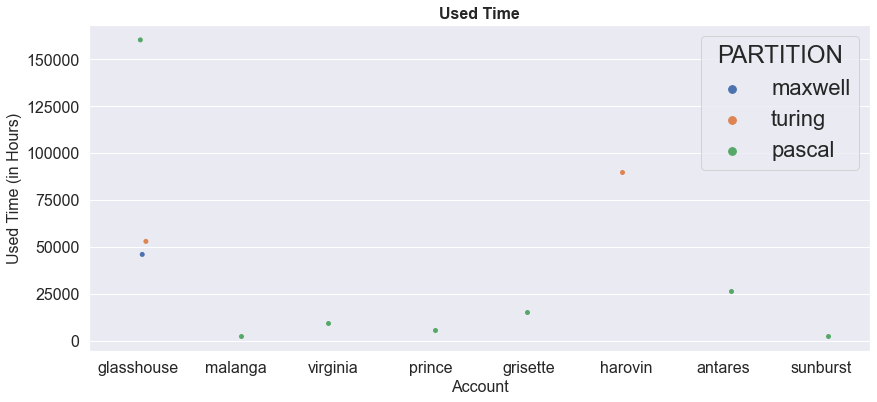

In [124]:
fontsize = 16

plt.subplots(figsize = (14, 6))
sns.stripplot(data = gpu_completed_df_Top20_Accounts_2.head(10) , x = 'ACCOUNT', y = 'USEDTIME_Hours', hue = 'PARTITION')
plt.xticks(fontsize = fontsize)
plt.xlabel('Account', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Used Time (in Hours)', fontsize = fontsize)
plt.title('Used Time', fontsize = fontsize, fontweight = 'bold')

xmin, xmax = plt.xlim()
#plt.hlines(y = 27.5, xmin = xmin, xmax = xmax, linestyle = '--');






In [132]:
fig = px.scatter(gpu_completed_df_Top20_Accounts_2, x="REQTIME_Hours", y="USEDTIME_Hours",
          size="JOBID", color="ACCOUNT",
                 hover_name="PARTITION", log_x=True, size_max=60)
fig.show()
gpu_completed_df_Top20_Accounts_2



ACCOUNT PARTITION  REQTIME_Hours  USEDTIME_Hours       USEDMEM  \
0      glasshouse   maxwell   1.804962e+06    46154.247222  1.269025e+08   
1      glasshouse    turing   4.495486e+05    53106.674722  2.373583e+08   
2      glasshouse    pascal   1.614662e+06   160402.300556  9.812095e+07   
3         malanga    pascal   4.753440e+05     2508.606667  4.746145e+05   
4        virginia    pascal   1.032533e+06     9752.405000  3.572546e+07   
5          prince    pascal   2.274385e+04     6037.130833  2.505292e+07   
6        grisette    pascal   3.314860e+05    15535.382778  3.519797e+07   
7         harovin    turing   5.347660e+05    90274.837500  2.834613e+07   
8         antares    pascal   2.037474e+05    26643.297500  1.656117e+07   
9        sunburst    pascal   1.331600e+05     2858.116111  3.674696e+05   
10        plumcot   maxwell   9.111185e+04     4116.344722  2.657585e+06   
11       virginia    turing   1.172800e+04     6899.760556  1.606602e+07   
12         pecans    pascal   6.128172e+04     4616.035556  1.458480e+06   
13        pasilla    turing   7.669167e+02      142.452778  5.319890e+05   
14        pasilla   maxwell   2.396667e+02        3.985556  1.401675e+04   
15        pasilla    pascal   2.406667e+02       99.793611  3.493290e+03   
16         kinnow    pascal   7.417267e+03     1763.697222  2.466933e+06   
17        almonds    turing   8.998000e+03      647.675833  1.296163e+06   
18       bertanne    turing   1.205250e+03      205.256389  4.415936e+05   
19         cactus    turing   1.018240e+04      235.876667  3.772439e+05   
20        antares    turing   2.448000e+03       58.001111  3.392553e+05   
21          clara   maxwell   8.303633e+03     6463.001389  1.855386e+04   
22         orange   maxwell   6.880000e+03     4594.072500  3.090962e+06   
23      rosemarie    pascal   1.364400e+03        4.254722  1.980830e+04   
24         prince    turing   2.040000e+02      169.335556  3.086194e+05   
25    horseradish    pascal   5.644000e+03      483.200000  3.760822e+05   
26          apple    turing   4.062000e+03      310.253611  7.539953e+04   
27  sugranineteen    turing   4.870000e+02       72.609722  3.045740e+03   
28          white   maxwell   8.710000e+02      569.064444  4.534824e+04   
29       bertanne   maxwell   1.360000e+02       27.783056  3.864595e+04   
30         pinole    turing   1.025000e+03      370.590278  1.117187e+06   
31            gem    turing   2.885000e+02        2.238889  4.640805e+04   
32        packham    pascal   4.080000e+02      212.023056  2.359205e+04   
33       bertanne    pascal   6.500000e+00        1.607222  2.677300e+02   
34          bunch    turing   3.333333e-01        0.209444  6.090000e+00   
35         summer   maxwell   4.800000e+01       48.004722  9.266000e+01   

     JOBID  
0   125380  
1    68428  
2    43252  
3     9901  
4     8932  
5     7408  
6     5786  
7     4729  
8     3117  
9     1390  
10    1027  
11     624  
12     609  
13     477  
14     427  
15     425  
16     380  
17     189  
18     164  
19     113  
20      86  
21      76  
22      74  
23      55  
24      51  
25      48  
26      45  
27      31  
28      31  
29      27  
30      19  
31      19  
32       7  
33       4  
34       1  
35       1

In [ ]:
ACCRE_Completed[["PARTITION","REQTIME_SEC", "USEDTIME_SEC"]].groupby('PARTITION').sum()

In [ ]:
ACCRE_Completed.groupby(["PARTITION","GPUS"])["USEDMEM"].sum()

In [ ]:
ACCRE_Completed.groupby(['PARTITION', 'ACCOUNT'])['JOBID'].sum()
